# Housing Renovation Analysis

<img src="images/housing.jpg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Overview
This project uses linear regression analysis to infer how certain variables impact housing prices and by how much. Analysis of data from King County House Sales shows that house condition, grade, and bathroom number are three key features that can increase a house's price. Any home seller can use this information to make decisions on potential renovations. 

## Business Problem
A real estate agency is looking to guide homeowners who are looking to sell their houses. They want to provided these homeowners with analysis of how renovations may impact the price of their home.

## Data Understanding
This project uses data from the King County House Sales dataset. It includes information on house age, size, condition and other features.

In [330]:
#import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_validate, ShuffleSplit
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [277]:
#load and preiview data
df = pd.read_csv('data/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The data has six non-numeric columns that will need to be manipulated or removed: "date", "waterfront", "view", "condition", "grade", and "sqft_basement". 

## Data Preparation

### Data Cleaning
Drop irrelevant columns, address missing values and manipulate data into desired forms

In [279]:
#drop irrelevant columns
df.drop(['id', 'date', 'zipcode', 'lat', 'long', 'yr_renovated', 'view'],
        axis=1, inplace=True)

In [280]:
#fill in missing sqft_basement values
df.loc[df.sqft_basement == '?', 'sqft_basement'] = (df[df.sqft_basement 
                                                       == '?'].sqft_living
                               - df[df.sqft_basement == '?'].sqft_above)

#convert into numeric
df['sqft_basement'] = df.sqft_basement.astype('float64')

#sqft_basement is a zero inflated variable, so I convert it into 
#a categorical variable
df['is_basement'] = df.sqft_basement.map(lambda x: 0 if x == 0 else 1)
df.drop('sqft_basement', axis=1, inplace=True)

In [281]:
#convert condition and grade into numeric values
df['condition'] = df.condition.map(lambda x: 1 if x=='Poor' 
                                   else (2 if x=='Fair'
                                    else (3 if x=='Average'
                                    else  (4 if x=='Good' else 4))))

df['grade'] = df.grade.map(lambda x: int(x[0:2]))

In [282]:
#convert waterfront strings to 0 and 1
df['waterfront'] = df.waterfront.map(lambda x: 0 if x=="NO" 
                                     else (1 if x=="YES" else None))

#create new column indicating if waterfront value is missing
waterfront = df[["waterfront"]]
missing_indicator = MissingIndicator()
missing_indicator.fit(waterfront)
waterfront_missing = missing_indicator.transform(waterfront)

df['waterfront_missing'] = waterfront_missing

df['waterfront_missing'] = df.waterfront_missing.map(lambda x: 0 if x==False
                                         else 1)

In [283]:
#fill in missing waterfront values with median
imputer = SimpleImputer(strategy="median")

imputer.fit(waterfront)
waterfront_imputed = imputer.transform(waterfront)

df['waterfront'] = waterfront_imputed

### Log Transformation
Determine which skewed variables are fixed through log transforms

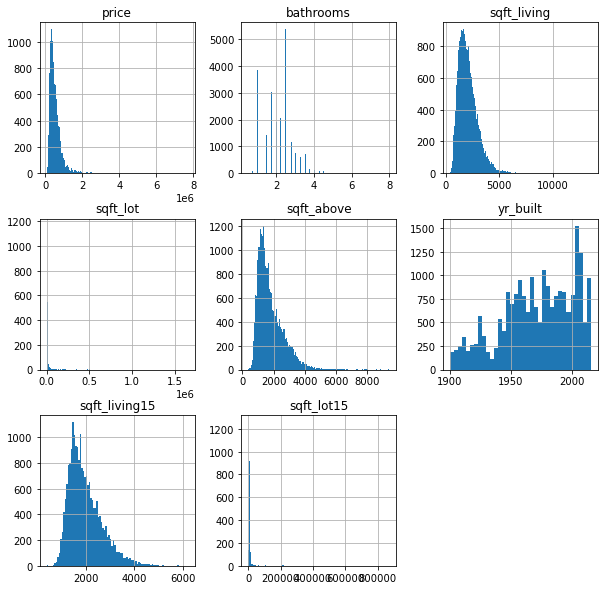

In [284]:
#examine distributions of continuous variables
cont_data = df.loc[:, ((df.dtypes != 'object') & (df.nunique() > 20))]
cont_data.hist(bins='auto', figsize=(10,10));

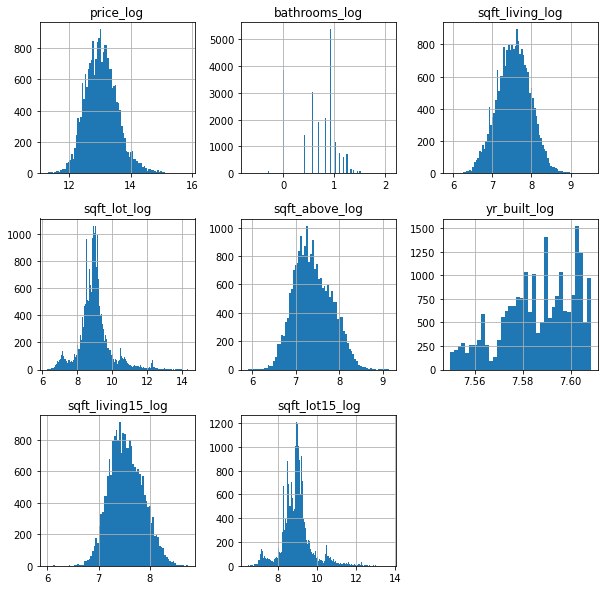

In [285]:
#log transforms of continuous variables
log_names = [f'{column}_log' for column in cont_data.columns]

log_data = np.log(cont_data);
log_data.columns = log_names;
log_data.hist(figsize=(10, 10), bins='auto');

With the exception of yr_built and bathrooms, log transforming the other variable improved the skewness of the data. I will replace the original data of these variables with the log transformed data.

In [286]:
#drop variables not included in log transformed data
cont_data.drop(['bathrooms', 'yr_built'], axis=1, inplace=True)
log_data.drop(['bathrooms_log', 'yr_built_log'], axis=1, inplace=True)

C:\Users\bento\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [287]:
#replace continuous variables with log transforms
df.drop(cont_data.columns, axis=1, inplace=True)
df = pd.concat([df, log_data],  axis=1)

### Split Data
I split the data into a training and test set. The training set will be used to build a model. The model will be validated on the test set.

In [288]:
#assaing independent(X) and dependent(y) variables
X = df.drop('price_log', axis=1)
y = df.price_log

In [289]:
#plit the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Feature Scaling
The features in this dataset have different scales so I standardize all non-binary independent variable to insure some aren't improperly weighted in the model.

In [290]:
#X_train feature scaling
std_scale = preprocessing.StandardScaler().fit(X_train.drop(['waterfront', 'waterfront_missing'], axis=1))
data_std = std_scale.transform(X_train.drop(['waterfront', 'waterfront_missing'], axis=1))
data_std = pd.DataFrame(data_std, columns=X_train.drop(['waterfront', 'waterfront_missing'], axis=1).columns,
                       index=X_train.index)

In [291]:
#replace original data with standardized data
X_train_std = pd.concat([data_std, X_train[['waterfront', 'waterfront_missing']]], axis=1)

In [292]:
#X_test feature scaling
std_scale = preprocessing.StandardScaler().fit(X_test.drop(['waterfront', 'waterfront_missing'], axis=1))
data_std = std_scale.transform(X_test.drop(['waterfront', 'waterfront_missing'], axis=1))
data_std = pd.DataFrame(data_std, columns=X_test.drop(['waterfront', 'waterfront_missing'], axis=1).columns,
                       index=X_test.index)

In [293]:
#replace original data with standardized data
X_test_std = pd.concat([data_std, X_test[['waterfront', 'waterfront_missing']]],  axis=1)

## Linear Regression Modeling
Using the cleaned, transformed, and scaled data above, I will model the effects of the predictor variables on housing price.

### Baseline Model
The baseline model will predict housing price based on only the most highly correlated predictor variable.

In [298]:
#determine highest correlating feature with price
pd.concat([X_train_std, y_train], axis=1).corr().price_log.sort_values(
    ascending=False)

price_log             1.000000
grade                 0.703151
sqft_living_log       0.673033
sqft_living15_log     0.606663
sqft_above_log        0.584533
bathrooms             0.549806
bedrooms              0.333058
floors                0.310690
is_basement           0.211008
waterfront            0.163710
sqft_lot_log          0.135981
sqft_lot15_log        0.121442
yr_built              0.081561
condition             0.012668
waterfront_missing   -0.008472
Name: price_log, dtype: float64

House grade is most highly correlate with price at a value of 0.704

In [299]:
baseline_model = LinearRegression()

In [300]:
#define how many splits to make of training data
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

#score the model using only the grade data as a predictor
baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train_std[['grade']],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

#print training and validation scores
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.49829797762322364
Validation score: 0.48228385681051805


### Second Model
For the second model I will use all predictor variables and see if it improves the score compared to the baseline.

In [301]:
second_model = LinearRegression()

In [302]:
second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train_std,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

#print training and validation scores
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())

Train score:      0.6592713254768645
Validation score: 0.6569632715578406


Using all the predictors greatly improved the score compared to the baseline model.

### Third Model: Check for Multicollinearity
Using a model with all the variables will likely include multicollinearity which could negatively affect the coefficients of our predictors, so I use the variance inflation factor to determine if any variables should be removed due to multicollinearity.

In [303]:
vif = [variance_inflation_factor(X_train_std.values,
           i) for i in range(X_train_std.shape[1])]
pd.Series(vif, index=X_train_std.columns, 
          name="Variance Inflation Factor")

bedrooms               1.736688
bathrooms              3.247669
floors                 2.365900
condition              1.182162
grade                  2.994680
yr_built               1.726358
is_basement            4.534567
sqft_living_log       19.496619
sqft_lot_log           6.716088
sqft_above_log        19.316584
sqft_living15_log      2.734918
sqft_lot15_log         6.486189
waterfront             1.022740
waterfront_missing     1.000309
Name: Variance Inflation Factor, dtype: float64

Any variable with an inflation of 5 are exhibiting multicollinearity. Sqft_lot_log, sqft_living_log and sqft_above_log are all above 5 and will be removed from this model.

In [304]:
third_model = LinearRegression()

In [305]:
third_model_scores = cross_validate(
    estimator=third_model,
    X=X_train_std.drop(['sqft_lot_log', 'sqft_living_log',
                              'sqft_above_log'], axis=1),
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())

Train score:      0.649309332946577
Validation score: 0.6473421709758299


This model's score is slightly lower than the second model, but including multicollinearity in the model could be interfere with the accuracy of our coefficients, so this model is preferable to the second.

### Fourth Model
Select features to include in the model based on their p significance value. Any p values below 0.05 will be included.

In [312]:
#construct model using all predictor variables
model = sm.OLS(y_train, sm.add_constant(X_train_std.drop(['sqft_lot_log',
                              'sqft_living_log',
                              'sqft_above_log'], axis=1))).fit()

In [313]:
#features with p-values over 0.05
model.pvalues > 0.05

const                 False
bedrooms              False
bathrooms             False
floors                False
condition             False
grade                 False
yr_built              False
is_basement           False
sqft_living15_log     False
sqft_lot15_log        False
waterfront            False
waterfront_missing     True
dtype: bool

bedrooms and waterfront_missing were not significant, so our fourth model will exclude these two features.

In [314]:
fourth_model = LinearRegression()

In [315]:
fourth_model_scores = cross_validate(
    estimator=fourth_model,
    X=X_train_std.drop(['bedrooms', 'waterfront_missing', 'sqft_lot_log',
                              'sqft_living_log',
                              'sqft_above_log'], axis=1),
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", fourth_model_scores["train_score"].mean())
print("Validation score:", fourth_model_scores["test_score"].mean())

Train score:      0.6491852169005706
Validation score: 0.6474161405467833


The score of the model is slightly higher than our third model.

## Fifth Model
I will use sklearn feature selection to determine which data to include in this model

In [316]:
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_std.drop(['sqft_lot_log',
                              'sqft_living_log',
                              'sqft_above_log'], axis=1), y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train_std.drop(['sqft_lot_log',
                              'sqft_living_log',
                              'sqft_above_log'], axis=1).columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: False
bathrooms: True
floors: True
condition: True
grade: True
yr_built: True
is_basement: True
sqft_living15_log: True
sqft_lot15_log: True
waterfront: True
waterfront_missing: False


This process selected the same features as our p-significance model.

### Final Model
Given the results from our models above, the final model will include all predictors except sqft_lot_log, sqft_living_log, sqft_above_log, bedrooms, and waterfront_missing. 

In [317]:
X_train_final = X_train_std.drop(['bedrooms', 'waterfront_missing', 'sqft_lot_log',
                              'sqft_living_log',
                              'sqft_above_log'], axis=1)
X_test_final = X_test_std.drop(['bedrooms', 'waterfront_missing', 'sqft_lot_log',
                              'sqft_living_log',
                              'sqft_above_log'], axis=1)

In [318]:
final_model = LinearRegression()

In [319]:
#construct model using final selected data
final_model.fit(X_train_final, y_train)

LinearRegression()

In [320]:
#R-squared score of the test set
final_model.score(X_test_final, y_test)

0.652167338182391

## Check for Linear Regression Assumptions
To be able to use this model with confidence, it must meet the assumptions of linearity, normality, and homoscedasticity.

### Linearity

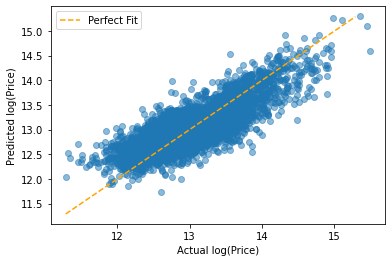

In [370]:
#predict the log(price) values based on X_test set
preds = final_model.predict(X_test_final)

#plot the predicted data vs the actual and compare to perfect line
fig, ax = plt.subplots()
perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual log(Price)")
ax.set_ylabel("Predicted log(Price)")
ax.legend();

The model is fairly linear, and thus fulfills the linearity assumption.

### Normality

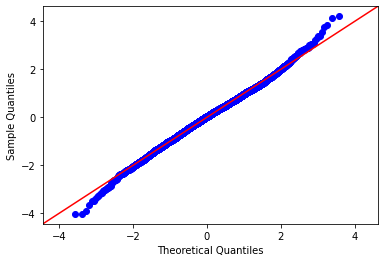

In [322]:
#calculate the residuals(differnce between actrual and predicted)
residuals = (y_test - preds)
#graph qq-plot
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

The qq-plot of the residuals is linear thus the normality assumption is fulfilled.

### Homoscedasticity

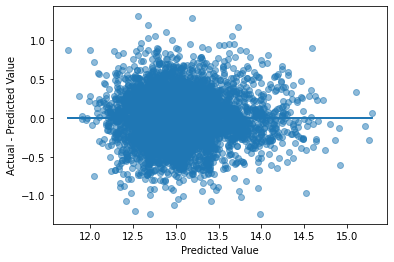

In [323]:
fig, ax = plt.subplots()

#plot the predicted data vs its residuals
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

The plot above is not too cone shaped thus the homoscedasticity assumption is fulfilled.

## Model Interpretation
With the model fulfilling the assumptions of linear regression, I can now interpret the model.

In [324]:
coefs = pd.Series(final_model.coef_, index=X_train_final.columns, name="Coefficients")
print(coefs)
print()
print("Intercept:", final_model.intercept_)

bathrooms            0.090722
floors               0.054162
condition            0.022421
grade                0.285988
yr_built            -0.182299
is_basement          0.050940
sqft_living15_log    0.122335
sqft_lot15_log      -0.028751
waterfront           0.539242
Name: Coefficients, dtype: float64

Intercept: 13.042760565159371


Given that I transformed and scaled the data, the coefficients listed above must be interpreted according the the transformation and scaling applied to each.

In [337]:
X_train.grade.std()

1.1726521444215625

In [343]:
(math.exp(coefs.grade) - 1)*100*(1/X_train.grade.std())

28.233088761336333

In [346]:
(math.exp(coefs.condition) - 1)*100*(1/X_train.condition.std())

4.568640809921405

In [348]:
(math.exp(coefs.bathrooms) - 1)*100*(1/X_train.bathrooms.std())

12.360989226526703

In [364]:
model = sm.OLS(y_train, sm.add_constant(X_train_final)).fit()

In [375]:
conf_int = model.conf_int(alpha=0.05)

In [391]:
conf_int.columns = ['Low', 'High']

In [392]:
conf_int

,Low,High
const,13.037935,13.047586
bathrooms,0.083122,0.098322
floors,0.047250,0.061075
condition,0.017220,0.027622
grade,0.278274,0.293701
yr_built,-0.188550,-0.176048
is_basement,0.045387,0.056493
sqft_living15_log,0.115055,0.129615
sqft_lot15_log,-0.034503,-0.022999
waterfront,0.479614,0.598869


In [367]:
model.params.bathrooms

0.0907220472607176

In [266]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     3396.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:38:07   Log-Likelihood:                -4075.6
No. Observations:               16197   AIC:                             8171.
Df Residuals:                   16187   BIC:                             8248.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.0437      0.002   5314.475      0.000      13.039      13.048
bathrooms             0.0905      0.004     23.297      0.000       0.083       0.098
floors                0.0554      0.004     15.674      0.000       0.048       0.062
condition             0.0265      0.003      9.994      0.000       0.021       0.032
grade                 0.2838      0.004     71.755      0.000       0.276       0.292
yr_built             -0.1806      0.003    -56.802      0.000      -0.187      -0.174
is_basement           0.0517      0.003     18.220      0.000       0.046       0.057
sqft_living15_log     0.1247      0.004     33.447      0.000       0.117       0.132
sqft_lot15_log       -0.0287      0.003     -9.785      0.000      -0.034      -0.023
waterfront            0.5748      0.030     18.954      0.000       0.515       0.634
==============================================================================
Omnibus:                       63.934   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.101
Skew:                          -0.016   Prob(JB):                     1.22e-19
Kurtosis:                       3.358   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusions

## Next Steps